In [1]:
%load_ext autotime

In [41]:
from google.cloud import firestore

import tempfile
from pathlib import Path
import numpy as np
from astropy import stats
import pandas as pd
import h5py

from astropy.io import fits
from astropy.visualization import simple_norm
from matplotlib.figure import Figure
import seaborn as sb
from IPython.display import display
from loguru import logger

from panoptes.utils.time import current_time
from panoptes.pipeline.utils import plot
from panoptes.pipeline.observation import make_stamps
from panoptes.utils.images import bayer
from panoptes.utils.serializers import from_json
from panoptes.utils.images import fits as fits_utils

firestore_db = firestore.Client()

sb.set_theme()

logger.remove()

time: 11.3 ms


In [3]:
current_time()

<Time object: scale='utc' format='datetime' value=2021-09-14 05:35:58.502393>

time: 3.5 ms


# Process an observation

## Setup the processing

In [4]:
# Input parameters
sequence_id = 'PAN012_358d0f_20180822T035809'
sequence_id = 'PAN012_358d0f_20191005T112325'  # Andromeda Galaxy
# sequence_id = 'PAN012_358d0f_20191024T121155'  # M82
sequence_id = 'PAN012_358d0f_20200207T043233'  # C2017 P2 Pan-Starrs

# Unused option for now. See below.
# vmag_min = 6
# vmag_max = 14

position_column_x = 'catalog_wcs_x'
position_column_y = 'catalog_wcs_y'

input_bucket = 'panoptes-images-processed'

# JSON string of additional settings.
observation_settings = '{}'
output_dir = tempfile.TemporaryDirectory().name

image_status = 'MATCHED'
base_url = 'https://storage.googleapis.com'

time: 1.41 ms


In [5]:
# Set up output directory and filenames.
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

observation_store_path = output_dir / 'observation.h5'

time: 668 µs


In [6]:
observation_settings = from_json(observation_settings)
observation_settings['output_dir'] = output_dir

time: 629 µs


Fetch all the image documents from the metadata store. We then filter based off image status and measured properties.

In [7]:
unit_id, camera_id, sequence_time = sequence_id.split('_')

# Get sequence information
sequence_doc_path = f'units/{unit_id}/observations/{sequence_id}'
sequence_doc_ref = firestore_db.document(sequence_doc_path)

time: 415 µs


In [8]:
# Get and show the metadata about the observation.
matched_query = sequence_doc_ref.collection('images').where('status', '==', image_status)
matched_docs = [d.to_dict() for d in matched_query.stream()]
images_df = pd.json_normalize(matched_docs, sep='_')

# Set a time index.
images_df.time = pd.to_datetime(images_df.time)
images_df = images_df.set_index(['time']).sort_index()

num_frames = len(images_df)
print(f'Found {num_frames} images in observation')

Found 58 images in observation
time: 1.26 s


In [9]:
# Sigma filtering of certain stats
mask_columns = [
    'camera_colortemp',
    'sources_num_detected',
    'sources_photutils_fwhm_mean'
]

for mask_col in mask_columns:
    images_df[f'mask_{mask_col}'] = stats.sigma_clip(images_df[mask_col]).mask
    display(plot.filter_plot(images_df, mask_col, sequence_id))
    

images_df['is_masked'] = False
images_df['is_masked'] = images_df.filter(regex='mask_*').any(1)

time: 587 ms


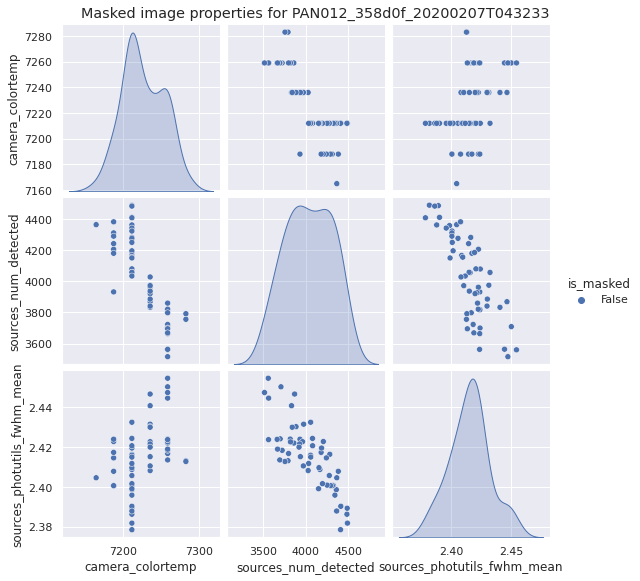

time: 1.36 s


In [10]:
pg = sb.pairplot(images_df[['is_masked', *mask_columns]], hue='is_masked')
pg.fig.suptitle(f'Masked image properties for {sequence_id}', y=1.01)
pg.fig.set_size_inches(9, 8);

In [11]:
# Get the unfiltered frames
images_df = images_df.query('is_masked==False')

num_frames = len(images_df)
print(f'Frames after filtering: {num_frames}')

Frames after filtering: 58
time: 74.4 ms


In [12]:
if num_frames < 10:
    raise RuntimeError(f'Cannot process with less than 10 frames,have {num_frames}')

time: 328 µs


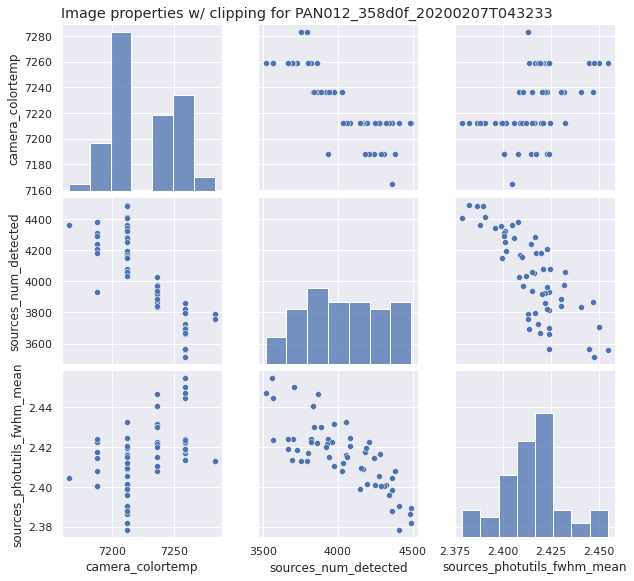

time: 1.03 s


In [13]:
pg = sb.pairplot(images_df[mask_columns])
pg.fig.suptitle(f'Image properties w/ clipping for {sequence_id}', y=1.01)

pg.fig.set_size_inches(9, 8);

In [14]:
# Save (most of) the images info to the observation store.
images_df.select_dtypes(exclude='object').to_hdf(observation_store_path, key='images', format='table', errors='ignore')

time: 39.5 ms


#### Load metadata for all images

In [15]:
# Build the joined metadata file.
sources = list()
for image_id in images_df.uid:
    blob_path = f'gcs://{input_bucket}/{image_id.replace("_", "/")}/sources.parquet'
    sources.append(pd.read_parquet(blob_path))

sources_df = pd.concat(sources).sort_index()
del sources

time: 1min 52s


## Filter stars

We get the mean metadata values for each star and use that to filter any outliers based on a few properties of the observation as a whole. 

The (gini coefficient)[https://photutils.readthedocs.io/en/stable/api/photutils.morphology.gini.html]

In [16]:
# Use the mean value for the observation for each source.
sample_source_df = sources_df.groupby('picid').mean()

time: 43.8 ms


In [17]:
num_sources = len(sample_source_df)
print(f'Sources before filtering: {num_sources}')

Sources before filtering: 5335
time: 532 µs


In [18]:
frame_count = sources_df.groupby('picid').catalog_vmag.count()
exptime = images_df.camera_exptime.mean()

# Mask sources that don't appear in all (filtered) frames.
sample_source_df['frame_count'] = frame_count

time: 7.01 ms


In [19]:
sample_source_df.eval('mask_frame_count = frame_count!=frame_count.max()', inplace=True)

time: 8.6 ms


In [20]:
# Sigma clip columns.
clip_columns = [
    'catalog_vmag',
    'photutils_gini',
    'photutils_fwhm',
]

# Display in pair plot columns.
pair_columns = [
    'catalog_sep',
    'photutils_eccentricity',
    'photutils_background_mean',
    'catalog_wcs_x_int',
    'catalog_wcs_y_int',
    'is_masked',
]

time: 441 µs


In [21]:
for mask_col in clip_columns:
    sample_source_df[f'mask_{mask_col}'] = stats.sigma_clip(sample_source_df[mask_col]).mask
    
# sample_source_df.eval('mask_catalog_vmag = catalog_vmag > @vmag_max or catalog_vmag < @vmag_min', inplace=True)

time: 7.16 ms


In [22]:
sample_source_df['is_masked'] = False
sample_source_df['is_masked'] = sample_source_df.filter(regex='mask_*').any(1)

time: 3.25 ms


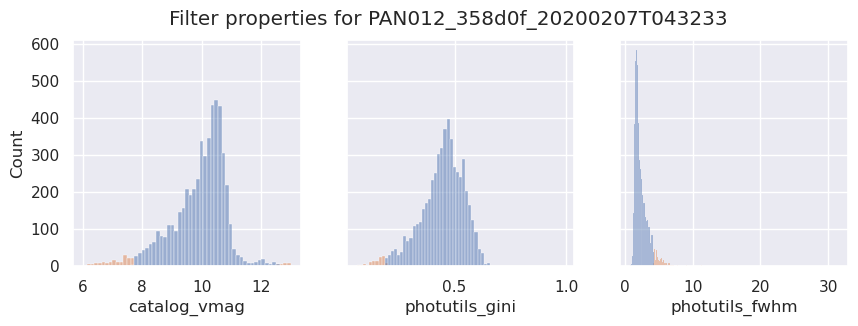

time: 1.22 s


In [23]:
fig = Figure()
fig.set_dpi(100)
fig.set_size_inches(10, 3)
axes = fig.subplots(ncols=len(clip_columns), sharey=True)
for i, col in enumerate(clip_columns):
    sb.histplot(data=sample_source_df, x=col, hue=f'mask_{col}', ax=axes[i], legend=False)

fig.suptitle(f'Filter properties for {sequence_id}')
fig

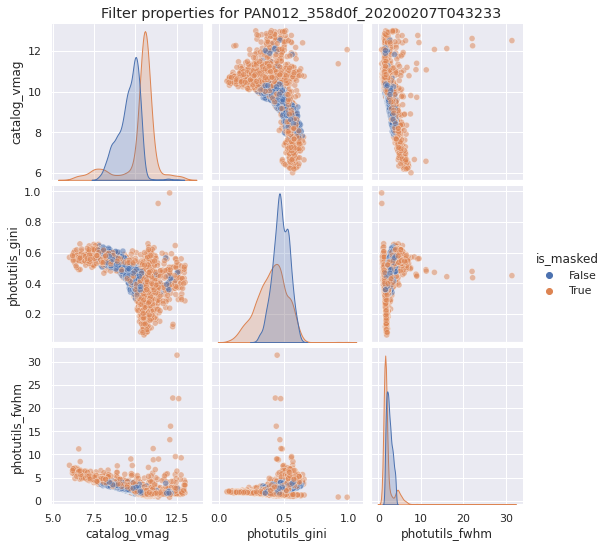

time: 2.73 s


In [24]:
pp = sb.pairplot(sample_source_df[clip_columns + ['is_masked']], hue='is_masked', plot_kws=dict(alpha=0.5))
pp.fig.suptitle(f'Filter properties for {sequence_id}', y=1.01);

In [25]:
pp = sb.pairplot(sample_source_df[clip_columns + pair_columns], hue='is_masked', plot_kws=dict(alpha=0.5))
pp.fig.suptitle(f'Catalog vs detected properties for {sequence_id}', y=1.01);

time: 19.8 s


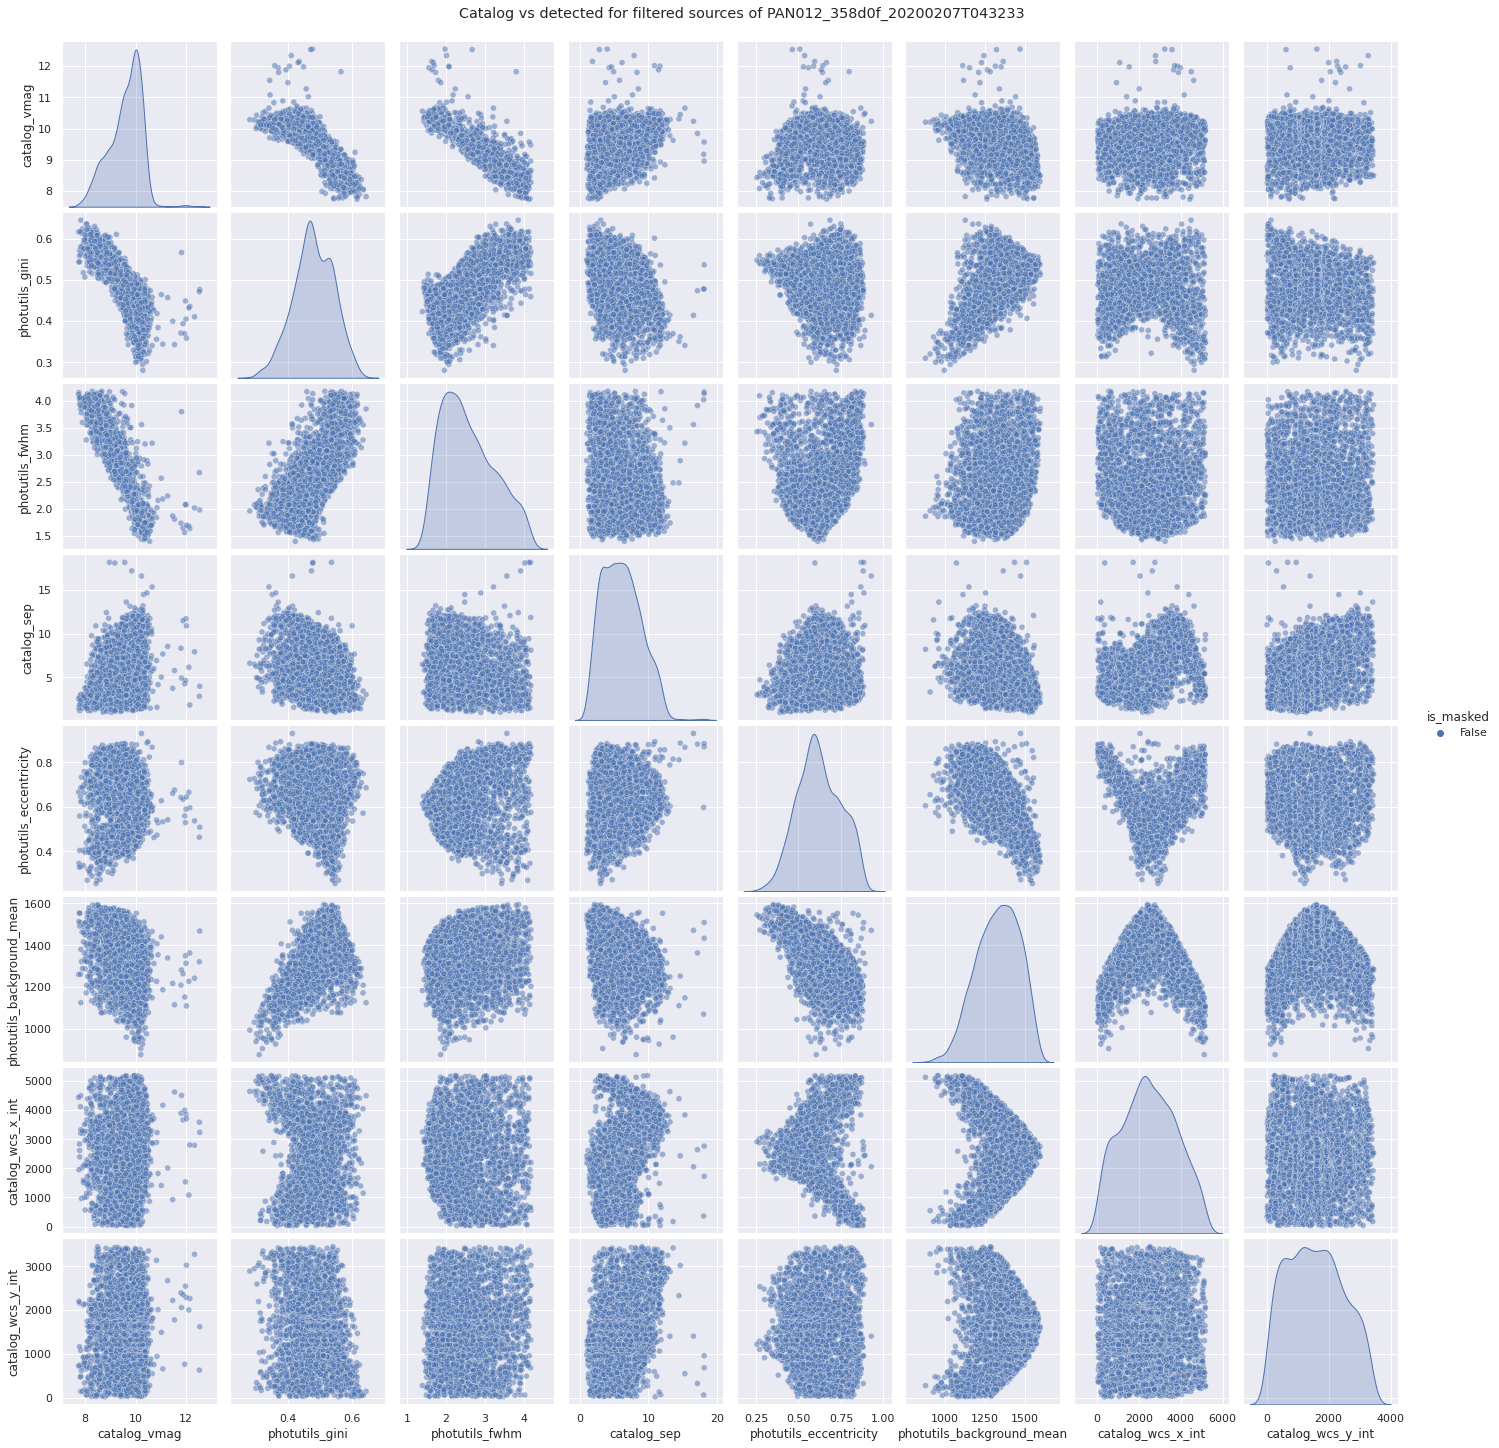

time: 17.8 s


In [26]:
pp = sb.pairplot(sample_source_df.query('is_masked==False')[clip_columns + pair_columns], hue='is_masked', plot_kws=dict(alpha=0.5))
pp.fig.suptitle(f'Catalog vs detected for filtered sources of {sequence_id}', y=1.01);

In [27]:
fig = Figure()
ax = fig.add_subplot()

plot_data = sample_source_df.query('is_masked == True')
sb.scatterplot(data=plot_data, 
               x='catalog_wcs_x_int', 
               y='catalog_wcs_y_int', 
               marker='*', 
               hue='is_masked',
               palette=['r'],
               size='catalog_vmag_bin', sizes=(150, 50),
               ax=ax
              )
ax.set_title(f'Location of {len(plot_data)} outliers in {exptime}s for {sequence_id}')

fig.set_size_inches(12, 8)

fig

time: 502 ms


In [28]:
fig = Figure()
fig.set_dpi(100)
ax = fig.add_subplot()

plot_data = sample_source_df.query('is_masked == False')
sb.scatterplot(data=plot_data, 
               x='catalog_wcs_x_int', 
               y='catalog_wcs_y_int', 
               marker='*', 
               hue='photutils_fwhm',
               palette='Blues',
               edgecolor='k',
               linewidth=0.2,
               size='catalog_vmag_bin', sizes=(100, 5),
               ax=ax
              )
ax.set_title(f'Location of {len(plot_data)} detected stars in {exptime}s for {sequence_id}')

fig.set_size_inches(12, 8)

fig

time: 784 ms


In [29]:
# Get the sources that aren't filtered.
sources_df = sources_df.loc[sample_source_df.query('is_masked == False').index]

time: 113 ms


In [30]:
num_sources = len(sources_df.index.get_level_values('picid').unique())
print(f'Detected stars after filtering: {num_sources}')

Detected stars after filtering: 2696
time: 4.9 ms


In [31]:
# Filter based on mean x and y movement of stars.
position_diffs = sources_df[['catalog_wcs_x_int', 'catalog_wcs_y_int']].groupby('picid').apply(lambda grp: grp - grp.mean())
pixel_diff_mask = stats.sigma_clip(position_diffs.groupby('time').mean()).mask

x_mask = pixel_diff_mask[:, 0]
y_mask = pixel_diff_mask[:, 1]

print(f'Filtering {sum(x_mask | y_mask)} of {num_frames} frames based on pixel movement.')

filtered_time_index = sources_df.index.get_level_values('time').unique()[~(x_mask | y_mask)]

# Filter sources
sources_df = sources_df.reset_index('picid').loc[filtered_time_index].reset_index().set_index(['picid', 'time']).sort_index()
# Filter images
images_df = images_df.loc[filtered_time_index]
num_frames = len(filtered_time_index)
print(f'Now have {num_frames}')

Filtering 0 of 58 frames based on pixel movement.
Now have 58
time: 3.4 s


In [32]:
fig = Figure()
fig.set_size_inches(8, 4)
ax = fig.add_subplot()
position_diffs.groupby('time').mean().plot(marker='.', ax=ax)

# Mark outliers
pd.DataFrame(position_diffs.groupby('time').mean()[x_mask]['catalog_wcs_x_int']).plot(marker='o', c='r', ls='', ax=ax, legend=False)
pd.DataFrame(position_diffs.groupby('time').mean()[y_mask]['catalog_wcs_y_int']).plot(marker='o', c='r', ls='', ax=ax, legend=False)

ax.set_title(f'Mean xy pixel movement {sequence_id}')
fig

time: 265 ms


In [33]:
# Save sources to observation hdf5 file.
sources_df.to_hdf(observation_store_path, key='sources', format='table')
del sources_df

time: 657 ms


## Make stamp locations

In [35]:
xy_catalog = pd.read_hdf(observation_store_path, 
                         key='sources', 
                         columns=[position_column_x, position_column_y]).reset_index().groupby('picid')

# Get max diff in xy positions.
x_catalog_diff = (xy_catalog.catalog_wcs_x.max() - xy_catalog.catalog_wcs_x.min()).max()
y_catalog_diff = (xy_catalog.catalog_wcs_y.max() - xy_catalog.catalog_wcs_y.min()).max()

if x_catalog_diff >= 18 or y_catalog_diff >= 18:
    raise RuntimeError(f'Too much drift! {x_catalog_diff=} {y_catalog_diff}')

stamp_width = 10 if x_catalog_diff < 10 else 18
stamp_height = 10 if y_catalog_diff < 10 else 18

# Determine stamp size
stamp_size = (stamp_width, stamp_height)
print(f'Using {stamp_size=}.')

Using stamp_size=(18, 18).
time: 260 ms


In [36]:
# Get the mean positions
xy_mean = xy_catalog.mean()
xy_std = xy_catalog.std()

xy_mean = xy_mean.rename(columns=dict(
    catalog_wcs_x=f'{position_column_x}_mean',
    catalog_wcs_y=f'{position_column_y}_mean')
)
xy_std = xy_std.rename(columns=dict(
    catalog_wcs_x=f'{position_column_x}_std',
    catalog_wcs_y=f'{position_column_y}_std')
)

time: 8.43 ms


In [37]:
xy_mean = xy_mean.join(xy_std)

stamp_positions = xy_mean.apply(
    lambda row: bayer.get_stamp_slice(row[f'{position_column_x}_mean'],
                                      row[f'{position_column_y}_mean'],
                                      stamp_size=stamp_size,
                                      as_slices=False,
                                      ), axis=1, result_type='expand')

stamp_positions[f'{position_column_x}_mean'] = xy_mean[f'{position_column_x}_mean']
stamp_positions[f'{position_column_y}_mean'] = xy_mean[f'{position_column_y}_mean']
stamp_positions[f'{position_column_x}_std'] = xy_mean[f'{position_column_x}_std']
stamp_positions[f'{position_column_y}_std'] = xy_mean[f'{position_column_y}_std']

stamp_positions.rename(columns={0: 'stamp_y_min',
                                1: 'stamp_y_max',
                                2: 'stamp_x_min',
                                3: 'stamp_x_max'}, inplace=True)

time: 110 ms


In [38]:
stamp_positions.to_hdf(observation_store_path, key='positions', format='table')

time: 20.7 ms


## Extract stamps

In [39]:
# Get list of FITS file urls
fits_urls = [f'{base_url}/{input_bucket}/{image_id.replace("_", "/")}/image.fits.fz' for image_id in images_df.uid]

# Build the joined metadata file.
reference_image = None
diff_image = None
stack_image = None
for image_time, fits_url in zip(images_df.index, fits_urls):
    try:
        data = fits_utils.getdata(fits_url)
        if reference_image is None:
            reference_image = data
            diff_image = np.zeros_like(data)
            stack_image = np.zeros_like(data)
            
        # Get the diff and stack images.
        diff_image = diff_image + (data - reference_image)
        stack_image = stack_image + data
        
        # Get stamps data from positions.
        stamps = make_stamps(stamp_positions, data)
        
        # Add the time stamp to this index.
        time_index = [image_time] * num_sources
        stamps.index = pd.MultiIndex.from_arrays([stamps.index, time_index], names=('picid', 'time'))
        
        # Append directly to the observation store.
        stamps.to_hdf(observation_store_path, key='stamps', format='table', append=True)
    except Exception as e:
        print(f'Problem with {fits_url}: {e!r}')

time: 4min 25s


In [42]:
fits.HDUList([
    fits.PrimaryHDU(diff_image),
    fits.ImageHDU(stack_image / num_frames),
    ]).writeto(f'/app/output/{sequence_id}.fits', overwrite=True)

time: 127 ms


In [44]:
def image_simple(d0, title=None):
    fig = Figure()
    fig.set_size_inches(18, 12)
    ax = fig.subplots()

    ax.imshow(d0,
              origin='lower',
              norm=simple_norm(d0, stretch='sqrt', min_percent=10.50, max_percent=98.),
              cmap='Greys_r')

    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    if title:
        ax.set_title(title)

    return fig

time: 1.23 ms


In [45]:
image_simple(stack_image, title=f'Stack image for {sequence_id}')

time: 1.33 s


In [46]:
image_simple(diff_image, title=f'Diff image for {sequence_id}')

time: 1.35 s


In [ ]:
fits_urls

## Notebook environment info

In [ ]:
!jupyter --version

In [ ]:
current_time()